# Consensus motifs

---
# Before Class
In class today we will be building PWMs and using them to idenfity binding sites in a sequence.

Prior to class, please do the following:
1. Install `pdf2svg` on your machine:
    1. On linux: `$ sudo apt-get install pdf2svg`
    1. On mac: `$ brew install pdf2svg`
1. Install `seqlogo` in your b529 environment using: `$ pip install seqlogo`
1. For some machines, you will also need ghostscript: `$conda install ghostscript`
1. Review slides on PWMs in detail
1. Review the structure of a gene and why we reverse complement 
1. Review or read up on Python syntax for:
      1. numpy ndarray operations (https://docs.scipy.org/doc/numpy-1.15.0/user/quickstart.html)
      1. str.maketrans() and str.translate (https://docs.python.org/3/library/stdtypes.html#str.translate)
      1. seqlogo (https://github.com/betteridiot/seqlogo)
      1. functions from previous class


---
## Learning Objectives

1. Build motifs from consensus sequences
* Plot motifs as a sequence logo
* Use motifs to score sequence and identify matches

---
## Background

As seen in the lecture, one type of transcriptional regulation is through control by transcription factors. These bind specific sequences known as transcription factor binding sites (TFBS). Unlike our previous class, these sites are more degenerate than a specific sequence and so basic pattern matching through the use of regular expressions is not sufficient to describe these sequences.

Our goal today will be to implement the use of PWMs to identify binding sites for a specific TFBS.

We will need to install the seqlogo package to complete today's assignment:

```$ pip install seqlogo```

We also need the pdf to svg converter for the graphics:
On linux: ```$ sudo apt-get install pdf2svg```
On mac: ```$ brew install pdf2svg```

---
## Imports

In [1]:
import numpy as np

#import function from previous class for building sequence motif & idenfitying seqs matching to motif
from data_readers import get_fasta
from seq_ops import reverse_complement

---
## Build sequence motif

Given a provided list of sequence k-mers we are going to build a consensus motif. Recall from lecture slides...

$PFM = \begin{bmatrix}
    x_{A1} & x_{A2} & x_{A3} & \dots & x_{An} \\
    x_{C1} & x_{C2} & x_{C3} & \dots & x_{Cn} \\
    x_{G1} & x_{G2} & x_{G3} & \dots & x_{Gn} \\
    x_{T1} & x_{T2} & x_{T3} & \dots & x_{Tn}
\end{bmatrix}$

$PWM = log_{2} \Big(\frac{x_{ij} + p_{i}}{\sum_{i=A,C,G,T}x_{ij}+\sum_{i=A,C,G,T}p_{i}}\Big) - log_{2}(b_{i})$

Where, $x_{ij}$ is the number of times nucleotide $i$ is observed at position $j$, $p_{i}$ is the pseudocount or Laplace estimator, and $b_{i}$ is the expected probability ($\textit{a priori}$) of observing nucleotide $i$ overall. In this assignment, we will use a pseudocount of $0.25$ and a uniform background probability of $0.25$.

Using your code developed in the previous class and the FASTA file in data/class4.fa write a program to read in the raw sequence reads, convert these into a Position Frequency Matrix, and then convert this into a PWM. 

In [49]:
def build_pfm(sequences, length):
    """Function to build a PFM using entries from a fasta file

    Args:
        sequences (list): list of sequence strings
        length (int): size of pfm we are building

    Returns:
        pfm (numpy array): dimensions are 4xlength
        
    Pseudocode:
        Initialize 4xlength numpy array as pfm (standard row order is alphabetical: A, C, G, T)
        for each sequence:
            for j in 1 to sequence length:
                increment pfm[base, j]
    """
    
    # Initialize an empty numpy array
    pfm = np.zeros((4,length), dtype=int)

    # Add base-wise counts to the numpy array to build PFM matrix
    for seq in sequences:

        # Counter will track our position along the sequence (j)
        counter = 0

        # For each sequence we count which bases we see at each position (j)
        for char in list(seq):

            # An if/switch statement would work here, but this is an ASCII trick
            #  to convert A, C, G, T to integers 0, 1, 3, 2 respectively based
            #  on their binary representations that I include for those interested
            #  A more standard way in Python would be just using:
            #  dna_to_index = str.maketrans('ACGT', '0123')
            #  for char in list(seq.translate(dna_to_index))
            #  the ord() method will return the unicode for that character. 
            #  >> is a bitwise function. 
            pfm[((ord(char) >> 1 & 3), counter)] += 1

            # Increment counter along the sequence
            counter+=1

    # Because our trick above results in G and T in the wrong positions in the matrix
    #  we need to swap T and G rows for consistency
    pfm[3,:], pfm[2,:] = pfm[2,:], pfm[3,:].copy()

    # return PFM
    return pfm

In [16]:
#initialize with zeros in order to be able to add/count easily. 
# test_array = np.zeros((4,10), dtype = int)
# test_array

In [50]:
def build_pwm(pfm):
    """Function to build a PWM from a PFM

    Args:
        pfm (numpy array): dimensions are 4xlength

    Returns:
        pwm (numpy array): dimensions are 4xlength
        
    Pseudocode:
        Initialize 4xlength numpy array as pfm (standard row order is alphabetical: A, C, G, T)
        Calculate column sums as sums
        for i in A,C,G,T:
            for j in 1 to pfm length:
                pwm[i, j] = log2( (pfm[i,j] + p) / (sums[j] + p*4) ) - log2(background probability)
    """
    
    #initialize the pwm array which is empty and we will be filling it up. 
    #it has to be the same length as pfm. 
    
    #setting my variables for pseudocount and background probability 
    p_i = 0.25
    b_i = 0.25
    
    #initializing my new pwm array, that has four rows and has the same length as my pfm array. 
    #data type has to be a float since we have decimals. #number of rows and number of columns 
    
    # pwm = np.zeros((4, len(pfm)), dtype = int)
    #this will not work because 1) we need float due to decimals, 2) doing length of pfm only 
    
    #we want the same number of rows as the pfm array and the same number of columns or the length. 
    #we know the length from the pfm array, so just do len of that array: REMEMBER TO INDEX THE ARRAY. 
    pwm = np.zeros((4,len(pfm[1])), dtype= float)
    #we want the columns, so we need to have the axis = 0. 
    col_sum = pfm.sum(axis = 0)
    pfm_float = pfm.astype(np.float32)
    
   #for i in A,C,G,T which is the number of rows. These two for loops will be iterating through each 
   #grid square in the array so to speak. 
    
    for i in range(4): #iterating through the rows of the array (ncs). i is the nucleotide having problems here. 
        for j in range(len(pfm_float[1])): #the length or columns here. j is the position 
             pwm[i,j] = np.log2((pfm[i,j] + p_i) / (col_sum[j] + p_i*4)) - np.log2(b_i)         
    return pwm  


In [24]:
#sanity checks below!

In [20]:
array = np.array([1,2,3,4,5])
for i in array:
    calc = (1 + i)
    print(calc)

2
3
4
5
6


In [21]:
array[2]

3

In [22]:
array = np.zeros((4,5), dtype = int)
array

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [23]:
sum_tet = array.sum(axis = 0)
sum_tet

array([0, 0, 0, 0, 0])

In [24]:
array_2 = np.zeros((4, len(array)), dtype = float)
array_2
#excludes the 5th column. 

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [25]:
array_2 = np.zeros((4, len(array[0])), dtype = int)
array_2
#includes all the columns

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [45]:
array_2 = np.zeros((4, len(array[1])), dtype = int)
array_2
#includes all the columns 

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [46]:
array.shape

(4, 5)

In [32]:
array_3 = array.astype(np.float32)
array_3

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [47]:
len(array)

4

In [22]:
len(array[0])

5

In [37]:
x = range(4)
type(x)

range

In [14]:
for i in range(4):
    print(i)

0
1
2
3


In [51]:
# File containing the list of sequences for our PWM
file_name = 'data/class3.fa'

# Read sequences from file into list
sequences = []
for name, seq in get_fasta(file_name):
    sequences.append(seq)

# Build pfm
pfm = build_pfm(sequences, 20)
print (pfm)

# Build PWM
pwm = build_pwm(pfm)
print (pwm)

[[ 60   0  46  77   0   0 171  18  27 229   0 111   0   0   0  36  88   0
   37  72]
 [ 47  82  41   0 229 229   0 112 144   0   0   0   0   0   0 171   0 135
   96  74]
 [ 69  40 103 152   0   0  30  99  19   0 229 118 142 229 229   0 127  94
   32  70]
 [ 53 107  39   0   0   0  28   0  39   0   0   0  87   0   0  22  14   0
   64  13]]
[[ 0.06739929 -7.84549005 -0.31410859  0.42597298 -7.84549005 -7.84549005
   1.57447013 -1.65566549 -1.07730573  1.99528787 -7.84549005  0.95217147
  -7.84549005 -7.84549005 -7.84549005 -0.66558096  0.61803432 -7.84549005
  -0.62632153  0.32943563]
 [-0.28324763  0.51645372 -0.47916784 -7.84549005  1.99528787  1.99528787
  -7.84549005  0.96508158  1.32693746 -7.84549005 -7.84549005 -7.84549005
  -7.84549005 -7.84549005 -7.84549005  1.57447013 -7.84549005  1.23399473
   0.74322458  0.36882907]
 [ 0.26825212 -0.51457317  0.84450792  1.40480837 -7.84549005 -7.84549005
  -0.92662681  0.78750515 -1.57870351 -7.84549005  1.99528787  1.04020632
   1.30679479

---
## Plot motif as logo

A typical way to display PWMs is a sequence logo. This is plot displaying the information content at each base position in the motif that we just generated. An example is below:
<center><img src='./figures/demoLogo.png'/ width=600px></center>

See documentation for this package here: https://github.com/betteridiot/seqlogo

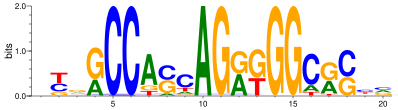

In [5]:
import seqlogo

# Use the seqlogo package to plot the PFM built above
# You will not need to edit anything here.
# The seqlogo expects the transpose of our pfm matrix, this can be done on a numpy array using the member function T: pfm.T

seqlogo.seqlogo(seqlogo.CompletePm(pfm = pfm.T))


---
## Identify sequence matches to motif

We are now going to scan the promoter regions (identified from last class) for matches to our motif. As we scan, consider each k-length sequence substring in both forward and reverse orientation for the entirety of each promoter.

In order to calculate the score at each position, we take the sum of the matching columns to a k-mer. This is becuase each position now represents the log likelihood of observing a base at that position:

k-mer : ACTAG

  | N | 1 | 2 | 3 | 4 | 5 |
  |:---:|:---:|:---:|:---:|:---:|:---:|
| A | **0.26** | 1.26 | -1.32 | **1.49** | -0.32 |
| C | -0.32 | **-0.32** | -1.32 | -1.32 | -1.32 |
| G | -1.32 | -1.32 | 1.49 | -1.32 | **1.0** |
| T | 0.68 | -1.32 | **-1.32** | -1.32 | -1.32 |
| $\sum$ | 0.26 | -0.32 | -1.32 | 1.49 | 1.0 |

= 1.11

In [52]:
# Write a function to score a string with your PWM generated above.
# Expected input: DNA string
# Expected output: highest score and location of best PWM match in the sequence
# Note: Remember to also scan the reverse compliment of the sequence!
def score_kmer(seq, pwm):
    """Function to score a kmer with a pwm
        kmer length is expected to be the same as pwm length

    Args:
        seq(str): kmer to score
        pwm (numpy array): pwm for scoring

    Returns:
        score (float): PWM score for kmer
        
    Pseudocode:
        score = 0
        for j in seq length
            score = score + pwm[seq[j], j]
    """
    # Initialize score to 0
    score = 0
    
    if len(seq) != len(pwm[0]):
        raise ValueError('K-mer and PWM are different lengths!')
    
    # Translator for DNA to numeric indices
    dna_to_index = str.maketrans('ACGT', '0123')
    
    # Iterate across kmer and sum log likelihoods
    for j, val in enumerate(list(seq.translate(dna_to_index)), 0): #not sure what that 0 is there for. 
        score += pwm[int(val), j]

    # Return score
    return score


def score_sequence(seq, pwm):
    """Function to score a long sequence with a pwm
        This will scan sequence and score all 
        subsequences of length k with a pwm
        and return the maximum score

    Args:
        seq(str): nmer to score
        pwm (numpy array): pwm for scoring

    Returns:
        score (float): PWM score for nmer
        position (int): 0-based index of the best match location
         Note: for negative strand still report left-most base position
        strand (int): 0 for positive strand, 1 for negative strand
        
    Pseudocode:
        max_score = -100
        for i pwm-length kmers in seq:
            if kmer > max:
                keep score, i, strand
                max = score
            if reverse compliment kmer > max:
                keep score, i, strand
                max = score            
            
    """
    #declare variables first. 
    max_score = -100
    max_index = None
    strand = None
    
    
    #raise error next 
#     if len(seq) != len(pwm[0]):
#         raise ValueError("The nmer is not the same size as the pmw.")
        
    if len(seq) < len(pwm[0]):
        raise ValueError("The nmer is smaller than the pwm.")
    
    #need to have 
    #may not need this here. 
    # if len(seq) != len(pwm[1]):
    #     raise ValueError("The Kmer and the pwm are not of the same length.")
 
    #use the score_kmer function here. 
    #I would need index the sequence (million nc seq) for the positive strand [0] add the kmer length.  #seq is the kmer 
    
    #0 plus the column length = var_1
    #for i in var_1:
    

    for i in range(0, len(seq) - len(pwm[0]) + 1): #sliding window of the nmer. 
        #score_kmer(kmer, pwm) 
        #this if will be for the forward strand. 
        if score_kmer(seq[i:len(pwm[0])+i], pwm) > max_score:   #> max_score 
            max_score = score_kmer(seq[i:len(pwm[0])+i], pwm) #i is already in kmer so just put i in the function. i will increment as it moves along sequence. 
            max_index = i 
            strand = 0
       
                          
        #this if will be for the reverse strand.             
        if score_kmer(reverse_complement(seq[i:(len(pwm[0])+i)]), pwm) > max_score: 
            max_score = score_kmer(reverse_complement(seq[i:(len(pwm[0])+i)]), pwm)
            max_index = i 
            strand = 1

        
    # for i in len(pwm[0])
    
#     for i in score_kmer(seq, pwm): #pwm-length kemers. 
#         if len(seq) > max:
#             print(score, i, #__ strand has to be postiive or negative.)
        
            #need to use the score_kmer function. 
            #print score (what's returned from the kmer function), i (in the for loop), and strand (the sequence) 
            
            
        #use reverse_complement function too. 
    
    return max_score, max_index, strand


In [31]:
x = 1
x

1

In [32]:
y = -1
y

-1

In [38]:
# Testing your functions. The following should output (7.477562910794718, 6, 0)
print (score_sequence('TAGAGAACAACCAAAAGAGGGGACAAGGGTATA', pwm))


(7.477562910794718, 6, 0)


In [54]:
def get_promoter_seq(seq, gene_start, gene_end, strand, size):
    '''Get the desired sub sequence from genomic coordinates
    
    Args:
        seq (str): nucleotide sequence
        gene_start (int): left-most position of gene CDS
        gene_end (int): right-most position of gene CDS
        strand (str): Whether the entry is on the forward (+), backward (-) strand or N/A (.)
        size (int): the size of the region to return
    
    Returns:
        desired_seq (str): the desired sub-sequence of seq at coordinates start-end corrected to + strand
        
    Example:
        >>> get_promoter_seq("ATTATATATATA", 2, 4, '-', 3) #doctest
        'ATA'
        
    '''

    desired_seq = ""
    #if strand is backwards, you need the reverse complement. 
    #remember you're only looking for three bases before the gene segment of interest. 
    if strand == "-":
        desired_seq = reverse_complement(seq[gene_end:(gene_end + size)])
    elif strand == "+":
        desired_seq = seq[(gene_start - size - 1):(gene_start - 1)]
    else:
        desired_seq = seq[(gene_start - size - 1):(gene_start - 1)]
    
    return desired_seq


In [58]:
# Now apply this to the code from last class to score the promoters
# You will need to extract all of the promoter regions (as done in the previous class)
# and then score these regions using your score_sequence() function above. Please output (print)
# the sequence, score of the best hit, position of the best hit, and the strand of the
# best hit.

# Import all of our class 2 functions
from data_readers import *
from seq_ops import *

seq_file="../class_03/Data_03/GCF_000009045.1_ASM904v1_genomic.fna.gz"
gff_file="../class_03/Data_03/GCF_000009045.1_ASM904v1_genomic.gff.gz"

#cut and paste from functions in class_02 and class_03. 
for name, seq in get_fasta(seq_file):
    for entry_gff in get_gff(gff_file):
        if entry_gff.type == "CDS":
            promoter_region = get_promoter_seq(seq, entry_gff.start, entry_gff.end, entry_gff.strand, 50)
            
            #Now score the regions:
            max_score, max_index, strand = score_sequence(promoter_region, pwm)
            print(promoter_region, max_score, max_index, strand)


ATAACAGAGAAAGACGCCATTTTCTAAGAAAAGGAGGGACGTGCCGGAAG -23.071250395597467 23 0
TATTTTTTATAAATATATATATTAATACATTATCCGTTAGGAGGATAAAA -22.348134892427357 29 0
TTTTTTTTAGTACAATTAGATATTAGTGATATTTGAAAGAGGTCGATATA -22.98052219123779 8 0
TTGAAGGATTTGGTTCATTTCAAGTCGTCAATTAAAGCGGGTGACACTGA -23.888959795304615 26 0
TTCCGTGTGCAAAATGGTGCGTTAGTGAAGTGAAGAAATGAGGTGAGCAA -25.745031359015147 2 0
TTTTTATCACGAATATATCGTTTAGAAAAGTGTAGGTGAATGACGTGGCT -26.38559862692238 24 0
GGACAATCTACTCCCACATATTTCATGTGATACTTCAGGGAGGTTTTTTA -23.67920392380161 25 0
GCGGGAAAGAGTTGAAATATTTAGATAACGGAAAGGATTAAGAAATATAC -26.568382712163594 24 0
TAGTTGATAATCTACATATAATATTTTGCCGAAAAGAGGGGGATTTACTA -15.346480923627693 27 0
CTTAACGGCTTAATTATAGATGAAGAAAATGAAATACGGAGGTCGTACGA -26.39941304828201 8 0
AATAAGGATTAGAAATCATATAACTATACCTTGATTAGGGGGACCAAGAA -27.49948378110619 27 0
AACAGCGTATGCAAGAACGCGGCTGGTAAGAACATAGGAGCGCTGCTGAC -23.009805849108574 7 0
TGAGGGCTCTTTTTATTTTCGATAAATCAATAAAAAAAGGAGTGTTTCGC -30.197884878041975 3 1
AATAAGAGCGACTTTGAACGCA